In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

# specify GPU
device = torch.device("cuda")

In [ ]:
# check class distribution
df['label'].value_counts(normalize = True)

,proportion
label,
0,0.865937
1,0.134063


In [ ]:
# split train dataset into train, validation and test sets
train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['label'],
                                                                    random_state=2018,
                                                                    test_size=0.3,
                                                                    stratify=df['label'])


val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=2018,
                                                                test_size=0.5,
                                                                stratify=temp_labels)



In [ ]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


<Axes: >

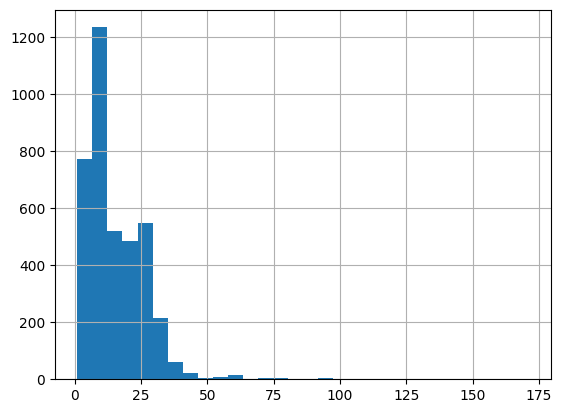

In [ ]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [ ]:
# tokenize and encode sequences in the training set # Token số

tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set #iteration and batching of the data during training and validation, we employ the DataLoader
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)


In [ ]:
# freeze all the parameters # leverage the pre-trained BERT model for transfer learning and adapt it to a specific task.
for param in bert.parameters():
    param.requires_grad = False #not to require gradients


In [ ]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
        super(BERT_Arch, self).__init__()

        self.bert = bert

        # dropout layer
        self.dropout = nn.Dropout(0.1)

        # relu activation function
        self.relu =  nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768,512)

        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(512,2)

        #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask): #obtain the output from the classification token

        #pass the inputs to the model
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)

        x = self.fc1(cls_hs)

        x = self.relu(x)

        x = self.dropout(x)

        # output layer
        x = self.fc2(x)

        # apply softmax activation
        x = self.softmax(x)

        return x

In [ ]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [ ]:
# optimizer from hugging face transformers
from transformers import AdamW

# Define the optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)

# Ensure train_labels is a NumPy array for compatibility
train_labels = np.array(train_labels)

# Compute the class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)

print("Class Weights:", class_weights)

Class Weights: [0.57743559 3.72848948]


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# push to GPU
weights = weights.to(device)

# define the loss function
cross_entropy  = nn.NLLLoss(weight=weights)

# number of training epochs
epochs = 10

In [ ]:
# function to train the model
def train():

    model.train()
    total_loss, total_accuracy = 0, 0

    # empty list to save model predictions
    total_preds=[]

    # iterate over batches
    for step,batch in enumerate(train_dataloader):

        # progress update after every 50 batches.
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

        # push the batch to gpu
        batch = [r.to(device) for r in batch]

        sent_id, mask, labels = batch

        # clear previously calculated gradients
        model.zero_grad()

        # get model predictions for the current batch
        preds = model(sent_id, mask)

        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)

        # add on to the total loss
        total_loss = total_loss + loss.item()

        # backward pass to calculate the gradients
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()

        # model predictions are stored on GPU. So, push it to CPU
        preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)

      # predictions are in the form of (no. of batches, size of batch, no. of classes).
      # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    #returns the loss and predictions
    return avg_loss, total_preds

In [ ]:
# function for evaluating the model
def evaluate():

    print("\nEvaluating...")

    # deactivate dropout layers
    model.eval()

    total_loss, total_accuracy = 0, 0

    # empty list to save the model predictions
    total_preds = []

    # iterate over batches
    for step,batch in enumerate(val_dataloader):

        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:

            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

        # push the batch to gpu
        batch = [t.to(device) for t in batch]

        sent_id, mask, labels = batch

        # deactivate autograd
        with torch.no_grad():

            # model predictions
            preds = model(sent_id, mask)

            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds,labels)

            total_loss = total_loss + loss.item()

            preds = preds.detach().cpu().numpy()

            total_preds.append(preds)

    # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader)

    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')

#defining epochs
epochs = 5

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):

    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    #train model
    train_loss, _ = train()

    #evaluate model
    valid_loss, _ = evaluate()

    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')

    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 5
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.647
Validation Loss: 0.624

 Epoch 2 / 5
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.614
Validation Loss: 0.592

 Epoch 3 / 5
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.586
Validation Loss: 0.567

 Epoch 4 / 5
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.564
Validation Loss: 0.539

 Epoch 5 / 5
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.547
Validation Loss: 0.515


In [ ]:
# get predictions for test data
with torch.no_grad():
    preds = model(test_seq.to(device), test_mask.to(device))
    preds = preds.detach().cpu().numpy()


# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))


              precision    recall  f1-score   support

           0       0.96      0.87      0.91       724
           1       0.48      0.79      0.60       112

    accuracy                           0.86       836
   macro avg       0.72      0.83      0.76       836
weighted avg       0.90      0.86      0.87       836




# test

In [ ]:
from transformers import BertTokenizer, BertForMaskedLM
import torch

# Khởi tạo tokenizer và mô hình BERT cho Masked Language Modeling
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
masked_lm_model = BertForMaskedLM.from_pretrained('bert-base-uncased')

# Đặt mô hình vào chế độ đánh giá
masked_lm_model.eval()

# Ví dụ câu với từ bị che
text = "The quick brown fox jumps over the [MASK] dog."

# Tokenize câu và thêm attention mask
inputs = tokenizer(text, return_tensors="pt")
mask_token_index = torch.where(inputs["input_ids"] == tokenizer.mask_token_id)[1]

# Dự đoán từ bị che
with torch.no_grad():
    outputs = masked_lm_model(**inputs)
    logits = outputs.logits

# Lấy các từ dự đoán hàng đầu cho vị trí [MASK]
mask_token_logits = logits[0, mask_token_index, :]
top_k = 5  # Số lượng từ dự đoán mong muốn
top_tokens = torch.topk(mask_token_logits, top_k, dim=1).indices[0].tolist()

# In các từ dự đoán
print("Câu ban đầu:", text)
print("Các từ dự đoán cho vị trí [MASK] là:")
for token in top_tokens:
    word = tokenizer.decode([token])
    print(f"  - {word}")


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a Bert

Câu ban đầu: The quick brown fox jumps over the [MASK] dog.
Các từ dự đoán cho vị trí [MASK] là:
  - little
  - big
  - small
  - startled
  - sleeping


# Phobert


In [ ]:
from transformers import AutoTokenizer, RobertaForMaskedLM
import torch

# Tải tokenizer và model PhoBERT
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)
model = RobertaForMaskedLM.from_pretrained("vinai/phobert-base")




config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of the model checkpoint at vinai/phobert-base were not used when initializing RobertaForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Câu ban đầu: Tôi thích học <mask> tại trường học.
Các từ dự đoán cho vị trí <mask> là:
  - văn_hoá
  - Toán
  - âm_nhạc
  - thêm
  - lịch_sử


In [ ]:
# Chuyển mô hình sang chế độ đánh giá
model.eval()

# Ví dụ câu tiếng Việt với từ bị che (dùng "<mask>")
text = "Tôi thích học <mask> tại trường học."

# Tokenize câu và xác định vị trí <mask>
input_ids = tokenizer.encode(text, return_tensors="pt")
mask_token_index = torch.where(input_ids == tokenizer.mask_token_id)[1]

# Dự đoán từ bị che
with torch.no_grad():
    outputs = model(input_ids)
    logits = outputs.logits

# Lấy các từ dự đoán hàng đầu cho vị trí <mask>
mask_token_logits = logits[0, mask_token_index, :]
top_k = 5  # Số lượng từ dự đoán mong muốn
top_tokens = torch.topk(mask_token_logits, top_k, dim=1).indices[0].tolist()



In [ ]:
# In các từ dự đoán
print("Câu ban đầu:", text)
print("Các từ dự đoán cho vị trí <mask> là:")
for token in top_tokens:
    word = tokenizer.decode([token])
    print(f"  - {word}")

Câu ban đầu: Tôi thích học <mask> tại trường học.
Các từ dự đoán cho vị trí <mask> là:
  - văn_hoá
  - Toán
  - âm_nhạc
  - thêm
  - lịch_sử
